In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_model import ARMA
from datetime import datetime
from itertools import product #数学类的函数 笛卡爾
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [4]:
#讀取數據
df=pd.read_csv('bitcoin_2012-01-01_to_2018-10-31.csv')

In [6]:
#將時間作為df索引
df.Timestamp=pd.to_datetime(df.Timestamp)
df.index=df.Timestamp

In [7]:
#數據探索
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,,
2011-12-31,2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2012-01-02,2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
2012-01-03,2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
2012-01-04,2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119578,5.208159


In [12]:
#按照月,季度,年來統計
#resample()进行重采样
df_month=df.resample('M').mean() #月
df_Q=df.resample('Q-DEC').mean() #季度
df_year=df.resample('A-DEC').mean() #年

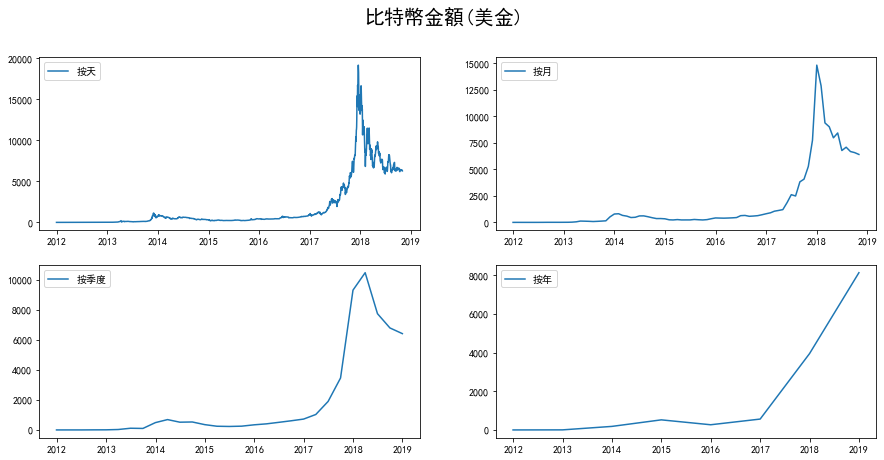

In [13]:
#按照天,月,季度,年來顯示比特幣的走勢
fig=plt.figure(figsize=[15,7]) #設置畫布寬15高7
plt.suptitle('比特幣金額(美金)',fontsize=20) #主標題

plt.subplot(221)  # 分成2x2，佔用第一個，即第一行第一列的子圖
plt.plot(df.Weighted_Price,'-',label='按天') #繪製按天平均走勢圖
plt.legend()#展示每个数据对应的图像名称

plt.subplot(222)
plt.plot(df_month.Weighted_Price,'-',label='按月')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price,'-',label='按季度')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price,'-',label='按年')
plt.legend()
plt.show()

In [16]:
#設置參數範圍
#p 和 q 的值，也就是 ARMA 中的阶数
ps=range(0,3)
qs=range(0,3)
parameters=product(ps,qs)
parameters_list=list(parameters)# [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

#尋找最優ARMA模型參數,即best_aic最小
results=[]
best_aic=float('inf')#正無窮

for param in parameters_list:
    try:
        model=ARMA(df_month.Weighted_Price,order=[param[0],param[1]]).fit()
    except ValueError:
        print('參數錯誤',param)
        continue
    aic=model.aic #AIC数值越小代表模型拟合得越好
    if aic<best_aic:
        best_model=model
        best_aic=aic
        best_param=param
    results.append([param,model.aic])#最優參數
#輸出最優模型
result_table=pd.DataFrame(results)
result_table.columns=['parameters','aic']
print('最優模型:',best_model.summary())

參數錯誤 (0, 2)
最優模型:                               ARMA Model Results                              
Dep. Variable:         Weighted_Price   No. Observations:                   83
Model:                     ARMA(1, 1)   Log Likelihood                -688.762
Method:                       css-mle   S.D. of innovations            957.776
Date:                Sun, 20 Sep 2020   AIC                           1385.524
Time:                        16:38:54   BIC                           1395.199
Sample:                    12-31-2011   HQIC                          1389.411
                         - 10-31-2018                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2154.0047   1571.238      1.371      0.170    -925.566    5233.575
ar.L1.Weighted_Price     0.9250      0.042     21.990      0.000       0.843       

In [43]:
#比特幣預測
df_month2=df_month[['Weighted_Price']]#選中每日均價
date_list=[datetime(2018,11,30),datetime(2018,12,31),#設置需要預測的時間
           datetime(2019,1,31),datetime(2019,2,28),datetime(2019,3,31),
           datetime(2019,4,30),datetime(2019,5,31),datetime(2019,6,30)]
future=pd.DataFrame(index=date_list,columns=df_month.columns) #設置表格格式
df_month2=pd.concat([df_month2,future]) #默認直向合併表格
#2012-01-01到2018-10-31有91個月 所以start0,end=91
df_month2['forecast']=best_model.predict(start=0,end=91)

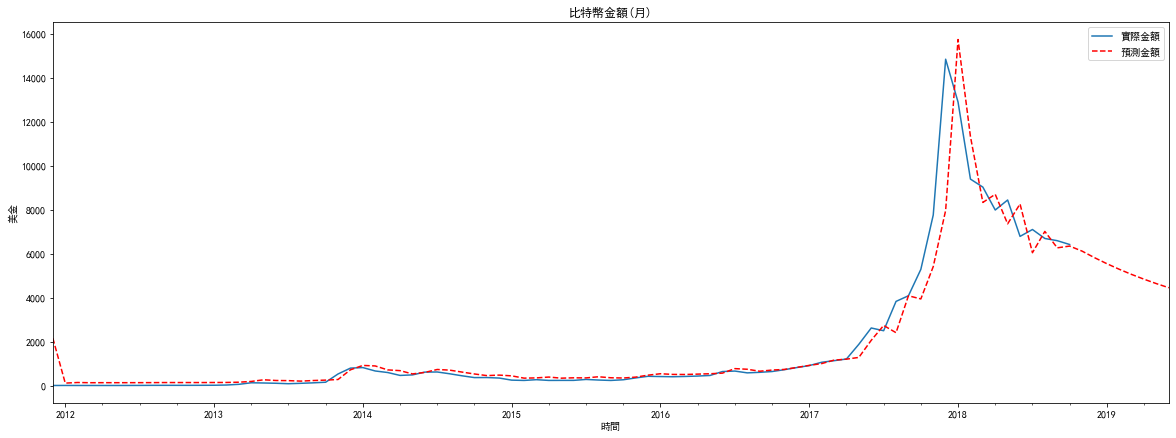

In [44]:
#比特幣預測結果顯示
plt.figure(figsize=(20,7))
df_month2.Weighted_Price.plot(label='實際金額')
df_month2.forecast.plot(color='r',ls='--',label='預測金額')
plt.legend()
plt.title('比特幣金額(月)')
plt.xlabel('時間')
plt.ylabel('美金')
plt.show()